In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm
import time
import pandas as pd

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

In [ ]:
import logging
logger = logging.getLogger(LOGGER_NAME)
logger.setLevel(logging.CRITICAL)

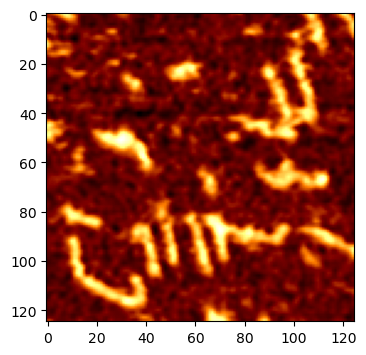

In [161]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getcwd())
FILE_EXT = ".gwy"
IMG_KEY = "PO-Wavemode125"
CONFIG = "config_PL.yaml"
IMG_FILES = [BASE_DIR.joinpath('data').joinpath(IMG_KEY+".gwy"),]

config = read_yaml(BASE_DIR.joinpath('data').joinpath(CONFIG))

loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(4, 4))
# When Topostats loads .gwy file, aspect ratio of the image is in img_dict.
plt.imshow(loaded_data.image, cmap="afmhot", aspect=loaded_data.img_dict[IMG_KEY]["scale"]["xy_aspect"])
plt.show()

In [162]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


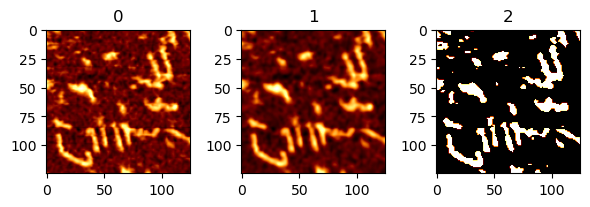

In [163]:
SHOW_TILE = True  # Set True to all images in the filtering result.
def tile_images(list_image, titles=[]):
    cols = len(list_image)
    if cols>4:
        raise ValueError()
    fig, ax = plt.subplots(1,cols,figsize=(6,6))
    if len(titles)!=cols:
        titles = [str(i) for i in range(cols)]
    for col in range(cols):
        ax[col].set_title(titles[col])
        ax[col].imshow(list_image[col], cmap="afmhot")
    fig.tight_layout()
    plt.show()

if SHOW_TILE:
    print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")

f_img = filtered_image.images
tile_images([f_img['zero_average_background'],f_img['gaussian_filtered'],f_img['mask']])

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting with 1 for all polymer chains. 

In [166]:
src_for_grain = filtered_image.images["zero_average_background"]
#src_for_grain = filtered_image.images["gaussian_filtered"]

config = read_yaml(BASE_DIR.joinpath('data').joinpath(CONFIG))
grain_config = config["grains"]
grain_config.pop("run")

def optimize_grain_threshold(src, filtered, start_th, end_th, step, **grain_config):
    grain_config["threshold_method"] = "std_dev"
    df = pd.DataFrame(columns=["threshold", "lbl1", "lbl2"])
    total = int(1 + (end_th - start_th) / step)
    for i in range(total):
        threshold = start_th + i * step
        grain_config["threshold_std_dev"]["above"] = threshold
        grains = Grains(
                        image=src,
                        filename=filtered.filename,
                        pixel_to_nm_scaling=filtered.pixel_to_nm_scaling,
                        **grain_config,
                        )
        grains.find_grains()
        lbl1 = grains.directions['above']['labelled_regions_01']
        lbl2 = grains.directions['above']['labelled_regions_02']
        (lbl1_cnt, lbl2_cnt) = (lbl1.max(), lbl2.max())
        data_row = pd.DataFrame([{"threshold":threshold, "lbl1":lbl1_cnt, "lbl2":lbl2_cnt}])
        df = pd.concat([df, data_row], axis=0, ignore_index=True)
    df["diff"] = df["lbl1"] - df["lbl2"]
    df["lbl2_criterion"] = (df["lbl2"] > (df["lbl2"].max() / 2))
    return df

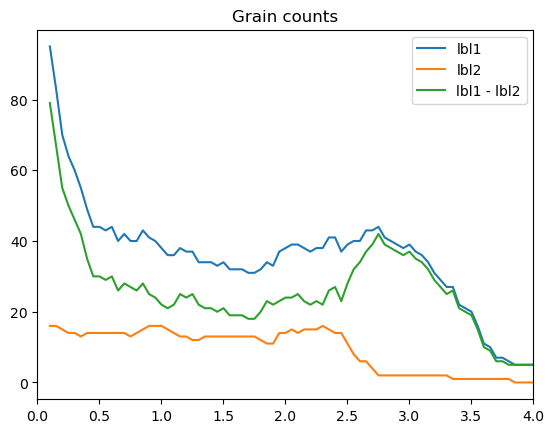

In [167]:
(MIN_STDEV, MAX_STDEV, STEP) = (0.1, 4.0, 0.05)
threshold_df = optimize_grain_threshold(src_for_grain, filtered_image, MIN_STDEV, MAX_STDEV, STEP, **grain_config)
x = threshold_df["threshold"]
y1 = threshold_df["lbl1"]
y2 = threshold_df["lbl2"]
yd = threshold_df["diff"]

fig, ax = plt.subplots()
ax.set_title("Grain counts")
ax.set_xlim(0.0, 4.0)
ax.plot(x, y1, label="lbl1")
ax.plot(x, y2, label="lbl2")
ax.plot(x, yd, label="lbl1 - lbl2")
plt.legend()
plt.show()



<Axes: xlabel='threshold', ylabel='lbl2'>

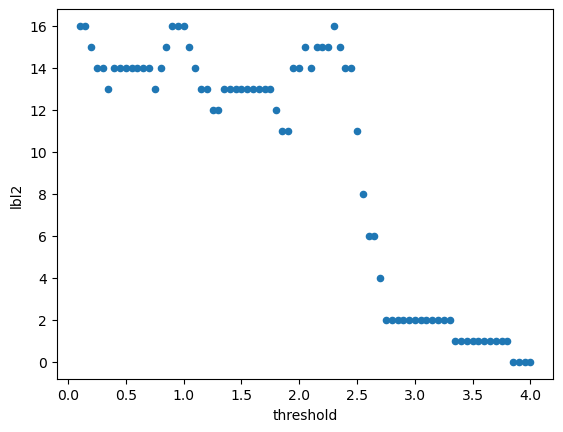

In [181]:
threshold_df.plot.scatter(x="threshold",y="lbl2")

In [178]:
# Proposed std_dev threshold values
max_lbl2 = threshold_df["lbl2"].max()
threshold_df.loc[threshold_df["lbl2"]==max_lbl2]

,threshold,lbl1,lbl2,diff,lbl2_criterion
0,0.10,95,16,79,True
1,0.15,83,16,67,True
16,0.90,41,16,25,True
17,0.95,40,16,24,True
18,1.00,38,16,22,True
44,2.30,38,16,22,True


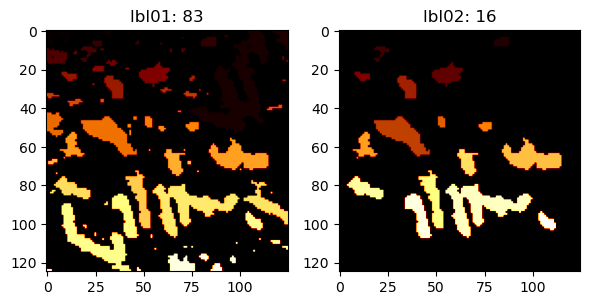

In [183]:
# Threshold for grain determines from the plot above, set it.5
#THRESHOLD_GRAIN = proposed_df.iloc[0]["threshold"]
THRESHOLD_GRAIN = 0.15

grain_config["threshold_std_dev"]["above"] = THRESHOLD_GRAIN
grains = Grains(
                image=src_for_grain,
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()
lbl1 = grains.directions['above']['labelled_regions_01']
lbl2 = grains.directions['above']['labelled_regions_02']
(grains1, grains2) = (lbl1.max(), lbl2.max())
tile_images([lbl1, lbl2], titles=[f"lbl01: {grains1}", f"lbl02: {grains2}"])

# Line detection

Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

This module has three classes to handle data processing.
- **`Line`** - contains pixel positions of a line
- **`Molecule`** - contains a molecule from preceding grain analysis
- **`LineDetection`** - tools to analyse linear part of molecules to generate results as Pandas.DataFrame

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`

### Overlapping lines
(Not implemented yet) Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [27]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection, Line

In [37]:
labelled = lbl1
source = filtered_image.images["gaussian_filtered"]

config = {"min_len":7, "max_len":20,"allowed_empty":1, "use_cache":True, "score_cutoff":0.5}

ld = LineDetection(labelled, source, **config)

In [38]:
count = 0
time0 = time.perf_counter()
for i in tqdm(range(len(ld.molecules))):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    if filtered is not None:
        lines_cnt = ld.score_lines(mol, filtered)
        if lines_cnt > 0:
            count += 1
time1 = time.perf_counter()
duration = time1 - time0
print(f"{count} molecules calculated in {duration:.3f}")

  0%|          | 0/166 [00:00<?, ?it/s]

29 molecules calculated in 5.075


In [39]:
ld.line_cache_hit

(23221, 80387)

In [40]:
ld.stat_df.sort_values("pixels")

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff
28,153,9,36,3,NaN,7,20,500,NaN
17,107,15,105,12,NaN,7,20,500,NaN
8,55,15,105,6,NaN,7,20,500,NaN
26,150,16,120,3,NaN,7,20,500,NaN
25,146,19,171,43,NaN,7,20,500,NaN
23,138,22,231,3,NaN,7,20,500,NaN
24,145,37,666,202,NaN,7,20,500,NaN
27,152,37,666,118,NaN,7,20,500,NaN
13,83,39,741,204,NaN,7,20,500,NaN
5,32,42,861,135,NaN,7,20,500,NaN


### line cache results
-> error is large in the conditions of PC with small number of calculation.

With cache         Without cache
(13066/65984)
9.671s             10.346s
9.887s              9.691s
9.887s             10.138s
10.246s            10.524s
10.226s            10.151s


In [41]:
# Save as pickle
SAVE_FILE = False
if SAVE_FILE:
    ld.score_df.to_pickle(IMG_KEY+"_score_df.pkl.gz")
    ld.stat_df.to_pickle(IMG_KEY+"_stat_df.pkl.gz")

In [42]:
# Result of line detection is in score_df
found_mol_count = len(ld.score_df.loc[ld.score_df["score"]>0].groupby("mol_idx").count())
print(f"{found_mol_count} molecules estimated (score > 0)")
maximum_length = ld.score_df.loc[ld.score_df["score"]>0]["length"].max()
print(f"Maximum length was {maximum_length:.2f}")
ld.score_df.loc[ld.score_df["score"]>0].sort_values("length", ascending=False)

26 molecules estimated (score > 0)
Maximum length was 20.00


,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
250,13,6.795662,1,9,0,21,16,20.000000,53.130102,2.342599
194,13,7.371794,0,10,1,22,17,20.000000,53.130102,2.824884
3106,122,6.534269,1,13,10,33,10,20.000000,0.000000,2.067084
3111,122,6.496123,1,14,10,34,10,20.000000,0.000000,2.036371
1500,77,7.424963,1,0,2,19,8,19.924859,17.525568,2.538517
...,...,...,...,...,...,...,...,...,...,...
1129,42,3.183134,0,6,6,13,6,7.000000,0.000000,0.550708
1460,71,3.313570,0,16,7,16,14,7.000000,90.000000,0.629475
918,24,3.868614,0,0,13,7,13,7.000000,0.000000,0.866392
1130,42,3.180646,0,7,6,14,6,7.000000,0.000000,0.546708


In [43]:
# Filtering statistics is in stat_df
ld.stat_df.sort_values("len_filtered", ascending=False).head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff
12,82,213,22578,13529,NaN,7,20,500,NaN
2,13,179,15931,10376,NaN,7,20,500,NaN
15,98,196,19110,10355,NaN,7,20,500,NaN
21,131,141,9870,6189,NaN,7,20,500,NaN
19,122,143,10153,6117,NaN,7,20,500,NaN


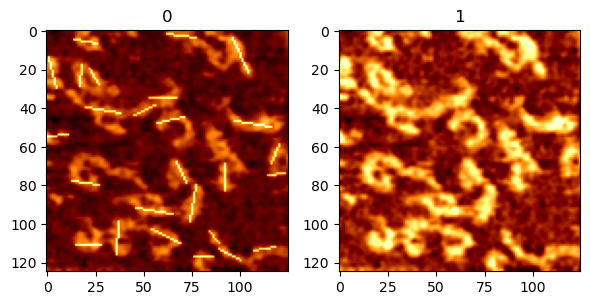

In [44]:
overlaid = ld.overlay_lines(num_lines=1, factor=20)
tile_images([overlaid, ld.source_img])

<AxesSubplot:xlabel='angle', ylabel='norm_score'>

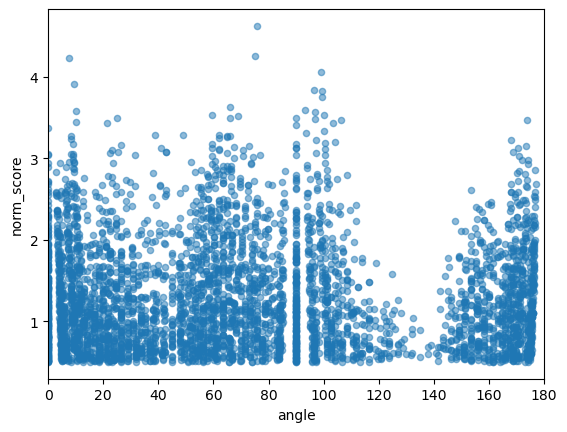

In [45]:
sorted_df = ld.score_df.sort_values("norm_score",ascending=False)
sorted_df[0:].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

In [40]:
ld.stat_df.median()

mol_idx          131.5
pixels            89.0
total_vecs      4136.5
len_filtered     219.0
total_lines        NaN
min_len            7.0
max_len           20.0
max_pix          500.0
score_cutoff       NaN
dtype: float64

# Normalized score

This normalization should be conducted for each molecule.

In [204]:
df = ld.score_df
mol_df = df.loc[(df["mol_idx"]==mol.mol_idx)].sort_values("norm_score",ascending=False)
mol_df[:3]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
4793,6,2.421355,0,2,0,5,9,9.486833,71.565051,2.719654
4794,6,2.384686,0,2,0,6,9,9.848858,66.037511,2.601413
4795,6,2.368856,0,1,0,6,9,10.295630,60.945396,2.550368


# Checking an individual molecule

In [221]:
ld.score_df.loc[ld.score_df["score"]>0].sort_values("length")

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
2547,6,2.300194,0,2,0,4,9,9.219544,77.471192,1.040988
2544,6,2.421355,0,2,0,5,9,9.486833,71.565051,1.595498
2545,6,2.384686,0,2,0,6,9,9.848858,66.037511,1.427677
1323,4,1.920277,0,2,0,2,10,10.000000,90.000000,2.295367
1324,4,1.846825,0,2,0,1,10,10.049876,95.710593,1.433032
...,...,...,...,...,...,...,...,...,...,...
4718,12,7.408631,0,0,10,26,28,31.622777,34.695154,2.468524
3188,10,7.428436,0,0,2,30,12,31.622777,18.434949,3.048193
4713,12,7.439649,0,1,11,28,28,31.906112,32.195734,2.491908
3171,10,7.842893,0,0,3,31,11,32.015621,14.470294,3.394748


In [222]:
ld.score_df.loc[ld.score_df["mol_idx"]==6].sort_values("norm_score",ascending=False)

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
2544,6,2.421355,0,2,0,5,9,9.486833,71.565051,1.595498
2545,6,2.384686,0,2,0,6,9,9.848858,66.037511,1.427677
2546,6,2.368856,0,1,0,6,9,10.295630,60.945396,1.355228
2547,6,2.300194,0,2,0,4,9,9.219544,77.471192,1.040988


In [205]:
def plot_emphasized_by_score(ld, mol, ilocs, use_max=False):
    """ Plot an emphasized line in src image"""
    mol_score = ld.score_df.loc[ld.score_df["mol_idx"]==mol.mol_idx]
    if len(mol_score)==0:
        return
    line_mask = mol.get_blank()
    for iloc in ilocs:
        row = mol_score.iloc[iloc].tolist()
        (x1,y1,x2,y2) = tuple(row[3:7])
        l = Line.create_from_pos(x1,y1,x2,y2).get_mask(mol.height, mol.width)
        line_mask = line_mask + l
    line_mask = line_mask / (len(ilocs))
    emp = ld.get_emphasized(mol,line_mask,factor=1.5, use_max=True)
    plt.imshow(emp)
    plt.plot()


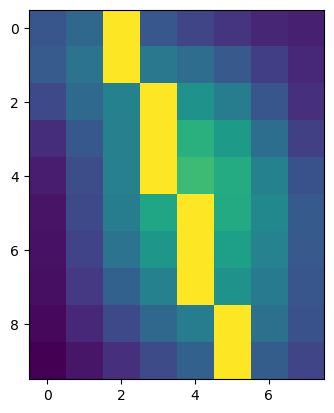

In [215]:
mol = ld.molecules[5]
plot_emphasized_by_score(ld, mol,range(0,1))

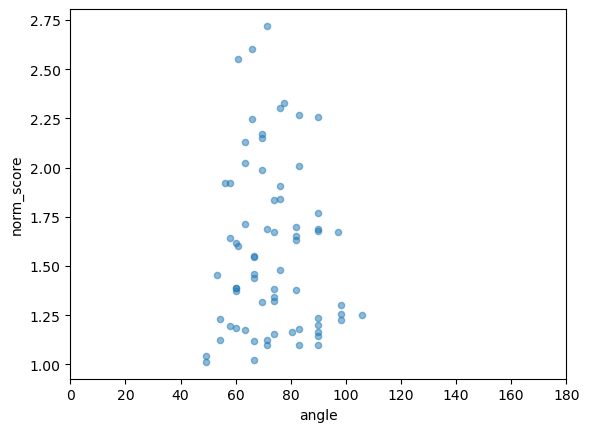

In [207]:
ret_mol = mol_df[0:100].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

<AxesSubplot:ylabel='Frequency'>

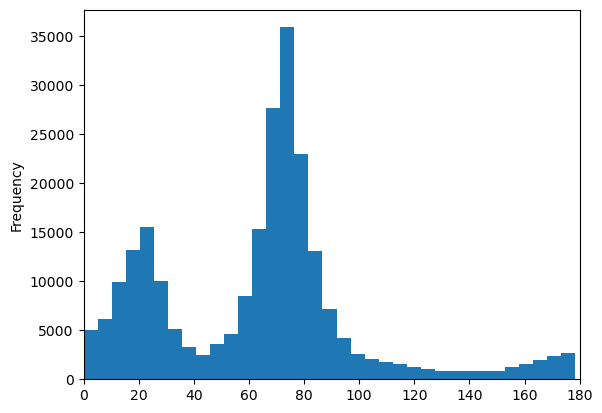

In [45]:

ld.score_df["angle"].plot.hist(bins=35, xlim=(0,180))
